# 1. Import libraries

In [1]:
# System modules
import os
import shutil
import joblib


# Scientific modules
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from abc import ABC, abstractmethod

# Environment
import gym

# Base agent
from copy import deepcopy


- *os* and *shutil* are modules for interacting with the operating system and file system
- *joblib* module is used here to save agent objects to files
- *numpy* and *matplotlib.pylab* are fundamental packages for scientific computing and plotting graphs
- *tqdm* package is used to display progress while running experiments
- *gym* is a standard API for reinforcement learning, and a diverse collection of reference environments
- *deepcopy* packages is used to create copies of mutable objects for agent training


# 2. Define Agent
Create abstract agent class to implement the agent for an RL-Glue environment.


In [2]:
"""An abstract class that specifies the Agent API for RL-Glue-py.
"""
class BaseAgent(ABC):
    """Implements the agent for an RL-Glue environment.
    Note:
        agent_init, agent_start, agent_step, agent_end, agent_cleanup, and
        agent_message are required methods.
    """

    def __init__(self):
        pass

    @abstractmethod
    def agent_init(self, agent_info= {}):
        """Setup for the agent called when the experiment first starts."""

    @abstractmethod
    def agent_start(self, observation):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            observation (Numpy array): the state observation from the environment's evn_start function.
        Returns:
            The first action the agent takes.
        """

    @abstractmethod
    def agent_step(self, reward, observation):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            observation (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """

    @abstractmethod
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the terminal state.
        """

    @abstractmethod
    def agent_cleanup(self):
        """Cleanup done after the agent ends."""

    @abstractmethod
    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent.
        Returns:
            The response (or answer) to the message.
        """

Create rocket agent to be trained. The agent uses Expected Sarsa to train a Deep Neural Network with a replay/experience buffer to store trajectories of experience when executing the policy in the lunar environment. During training, the replay buffer is queried for a sample of the trajectories to "replay" the agent's experience for learning. The replayed buffer can be queried several times in one agent step, the number of which is defined by "self.num_replay".

In [3]:
class ExperienceReplay_Agent(BaseAgent):
    def __init__(self):
        self.name = "expected_sarsa_agent"

    def agent_init(self, agent_config):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the agent.

        Assume agent_config dict contains:
        {
            network_config: dictionary,
            optimizer_config: dictionary,
            replay_buffer_size: integer,
            minibatch_sz: integer,
            num_replay_updates_per_step: float
            discount_factor: float,
        }
        """
        self.name = "expected_sarsa_agent_{}".format(agent_config['agent_name'])
        self.replay_buffer = ReplayBuffer(agent_config['replay_buffer_size'],
                                          agent_config['minibatch_sz'], agent_config.get("seed"))
        self.network = ActionValueNetwork(agent_config['network_config'])
        self.optimizer = Adam(self.network.layer_sizes, agent_config["optimizer_config"])
        self.num_actions = agent_config['network_config']['num_actions']
        self.num_replay = agent_config['num_replay_updates_per_step']
        self.discount = agent_config['gamma']
        self.tau = agent_config['tau']

        self.rand_generator = np.random.RandomState(agent_config.get("seed"))

        self.last_state = None
        self.last_action = None

        self.sum_rewards = 0
        self.episode_steps = 0

    def policy(self, state):
        """
        Args:
            state (Numpy array): the state.
        Returns:
            the action.
        """
        action_values = self.network.get_action_values(state)
        probs_batch = softmax(action_values, self.tau)
        action = self.rand_generator.choice(self.num_actions, p=probs_batch.squeeze())
        return action

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        self.sum_rewards = 0
        self.episode_steps = 0
        self.last_state = np.array([state])
        self.last_action = self.policy(self.last_state)
        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent: Action selection, replay-buffer update, 
        weights update using optimize_network, and update last_state and last_action
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """

        self.sum_rewards += reward
        self.episode_steps += 1

        # Make state an array of shape (1, state_dim) to add a batch dimension and
        # to later match the get_action_values() and get_TD_update() functions
        state = np.array([state])

        # Select action
        action = self.policy(state)

        # Append new experience to replay buffer
        self.replay_buffer.append(self.last_state, self.last_action, reward, 0, state)

        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()

                # Call optimize_network to update the weights of the network 
                optimize_network(experiences, self.discount, self.optimizer, self.network, current_q, self.tau)

        # Update the last state and last action.
        self.last_state = state
        self.last_action = action

        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.sum_rewards += reward
        self.episode_steps += 1

        # Set terminal state to an array of zeros
        state = np.zeros_like(self.last_state)

        # Append new experience to replay buffer
        self.replay_buffer.append(self.last_state, self.last_action, reward, 1, state)

        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()

                # Call optimize_network to update the weights of the network
                optimize_network(experiences, self.discount, self.optimizer, self.network, current_q, self.tau)

    def agent_cleanup(self):
        """Cleanup done after the agent ends."""
        
    def agent_message(self, message):
        if message == "get_sum_reward":
            return self.sum_rewards
        else:
            raise Exception("Unrecognized Message!")

## Replay/Experience Buffer
The experience buffer store trajectories of experience when executing the policy in the lunar environment. For each step, the buffer stores the current state and action, the reward and next state, and whether the agent reached a terminal state. During training, the replay buffer is queried for a sample of the trajectories to "replay" the agent's experience for learning.

In [4]:
class ReplayBuffer:
    def __init__(self, size, minibatch_size, seed):
        """
        Args:
            size (integer): The size of the replay buffer.
            minibatch_size (integer): The sample size.
            seed (integer): The seed for the random number generator.
        """
        self.buffer = []
        self.minibatch_size = minibatch_size
        self.rand_generator = np.random.RandomState(seed)
        self.max_size = size

    def append(self, state, action, reward, terminal, next_state):
        """
        Args:
            state (Numpy array): The state.
            action (integer): The action.
            reward (float): The reward.
            terminal (integer): 1 if the next state is a terminal state and 0 otherwise.
            next_state (Numpy array): The next state.
        """
        if len(self.buffer) == self.max_size:
            del self.buffer[0]
        self.buffer.append([state, action, reward, terminal, next_state])

    def sample(self):
        """
        Returns:
            A list of transition tuples including state, action, reward, terinal, and next_state
        """
        idxs = self.rand_generator.choice(np.arange(len(self.buffer)), size=self.minibatch_size)
        return [self.buffer[idx] for idx in idxs]

    def size(self):
        return len(self.buffer)

## Function approximator: Neural Network with Adam optimizer using Expected SARSA
The agent learns by training a neural network, which is used as a function approximator of the action-value function in the control problem. The output includes as many units as the number of actions. The weights of the action-value network are updated using the Adam algorithm.

In [5]:
class ActionValueNetwork:

    def __init__(self, network_config):
        self.state_dim = network_config.get("state_dim")
        self.num_hidden_units = network_config.get("num_hidden_units")
        self.num_actions = network_config.get("num_actions")

        self.rand_generator = np.random.RandomState(network_config.get("seed"))

        self.layer_sizes = [self.state_dim, self.num_hidden_units, self.num_actions]

        # Initialize the weights of the neural network
        # self.weights is an array of dictionaries with each dictionary corresponding to
        # the weights from one layer to the next. Each dictionary includes W and b
        self.weights = [dict() for i in range(0, len(self.layer_sizes) - 1)]
        for i in range(0, len(self.layer_sizes) - 1):
            self.weights[i]['W'] = self.init_saxe(self.layer_sizes[i], self.layer_sizes[i + 1])
            self.weights[i]['b'] = np.zeros((1, self.layer_sizes[i + 1]))

    def get_action_values(self, s):
        """
        Args:
            s (Numpy array): The state.
        Returns:
            The action-values (Numpy array) calculated using the network's weights.
        """

        W0, b0 = self.weights[0]['W'], self.weights[0]['b']
        psi = np.dot(s, W0) + b0
        x = np.maximum(psi, 0)

        W1, b1 = self.weights[1]['W'], self.weights[1]['b']
        q_vals = np.dot(x, W1) + b1

        return q_vals


    def get_TD_update(self, s, delta_mat):
        """
        Args:
            s (Numpy array): The state.
            delta_mat (Numpy array): A 2D array of shape (batch_size, num_actions). Each row of delta_mat
            correspond to one state in the batch. Each row has only one non-zero element
            which is the TD-error corresponding to the action taken.
        Returns:
            The TD update (Array of dictionaries with gradient times TD errors) for the network's weights
        """

        W0, b0 = self.weights[0]['W'], self.weights[0]['b']
        W1, b1 = self.weights[1]['W'], self.weights[1]['b']

        psi = np.dot(s, W0) + b0
        x = np.maximum(psi, 0)
        dx = (psi > 0).astype(float)

        # td_update has the same structure as self.weights, that is an array of dictionaries.
        # td_update[0]["W"], td_update[0]["b"], td_update[1]["W"], and td_update[1]["b"] have the same shape as
        # self.weights[0]["W"], self.weights[0]["b"], self.weights[1]["W"], and self.weights[1]["b"] respectively
        td_update = [dict() for i in range(len(self.weights))]

        v = delta_mat
        td_update[1]['W'] = np.dot(x.T, v) * 1. / s.shape[0]
        td_update[1]['b'] = np.sum(v, axis=0, keepdims=True) * 1. / s.shape[0]

        v = np.dot(v, W1.T) * dx
        td_update[0]['W'] = np.dot(s.T, v) * 1. / s.shape[0]
        td_update[0]['b'] = np.sum(v, axis=0, keepdims=True) * 1. / s.shape[0]

        return td_update


    def init_saxe(self, rows, cols):
        """
        Args:
            rows (int): number of input units for layer.
            cols (int): number of output units for layer.
        Returns:
            NumPy Array consisting of weights for the layer based on the initialization in Saxe et al.
        """
        tensor = self.rand_generator.normal(0, 1, (rows, cols))
        if rows < cols:
            tensor = tensor.T
        tensor, r = np.linalg.qr(tensor)
        d = np.diag(r, 0)
        ph = np.sign(d)
        tensor *= ph

        if rows < cols:
            tensor = tensor.T
        return tensor


    def get_weights(self):
        """
        Returns:
            A copy of the current weights of this network.
        """
        return deepcopy(self.weights)


    def set_weights(self, weights):
        """
        Args:
            weights (list of dictionaries): Consists of weights that this network will set as its own weights.
        """
        self.weights = deepcopy(weights)

The Adam algorithm is an extension to stochastic gradient descent. It is a combination of two gradient descent methods, Momentum, and Root Mean Square Propagation (RMSP). It keeps running estimates of the mean and second moment of the updates, denoted by $\mathbf{m}$ and $\mathbf{v}$ respectively:
$$\mathbf{m_t} = \beta_m \mathbf{m_{t-1}} + (1 - \beta_m)g_t \\
\mathbf{v_t} = \beta_v \mathbf{v_{t-1}} + (1 - \beta_v)g^2_t
$$

Here, $\beta_m$ and $\beta_v$ are fixed parameters controlling the linear combinations above and $g_t$ is the update at time $t$ (generally the gradients, but here the TD error times the gradients).

Given that $\mathbf{m}$ and $\mathbf{v}$ are initialized to zero, they are biased toward zero. To get unbiased estimates of the mean and second moment, Adam defines $\mathbf{\hat{m}}$ and $\mathbf{\hat{v}}$ as:
$$ \mathbf{\hat{m}_t} = \frac{\mathbf{m_t}}{1 - \beta_m^t} \\
\mathbf{\hat{v}_t} = \frac{\mathbf{v_t}}{1 - \beta_v^t}
$$
To calculate $\mathbf{\hat{m}}$ and $\mathbf{\hat{v}}$, we use powers of $\beta_m$ and $\beta_v$, respectively.
The weights are then updated as follows:
$$ \mathbf{w_t} = \mathbf{w_{t-1}} + \frac{\alpha}{\sqrt{\mathbf{\hat{v}_t}}+\epsilon} \mathbf{\hat{m}_t}
$$

Here, $\alpha$ is the step size parameter and $\epsilon$ is a small constant to keep the denominator from being zero.


In [6]:
class Adam():
    def __init__(self, layer_sizes,
                 optimizer_info):
        self.layer_sizes = layer_sizes

        # Specify Adam algorithm's hyper parameters
        self.step_size = optimizer_info.get("step_size")
        self.beta_m = optimizer_info.get("beta_m")
        self.beta_v = optimizer_info.get("beta_v")
        self.epsilon = optimizer_info.get("epsilon")

        # Initialize Adam algorithm's m and v
        self.m = [dict() for i in range(1, len(self.layer_sizes))]
        self.v = [dict() for i in range(1, len(self.layer_sizes))]

        for i in range(0, len(self.layer_sizes) - 1):
            # m and v are initialized to zero, with the same dimensions as the weights
            self.m[i]["W"] = np.zeros((self.layer_sizes[i], self.layer_sizes[i + 1]))
            self.m[i]["b"] = np.zeros((1, self.layer_sizes[i + 1]))
            self.v[i]["W"] = np.zeros((self.layer_sizes[i], self.layer_sizes[i + 1]))
            self.v[i]["b"] = np.zeros((1, self.layer_sizes[i + 1]))

        self.beta_m_product = self.beta_m
        self.beta_v_product = self.beta_v

    def update_weights(self, weights, td_errors_times_gradients):
        """
        Args:
            weights (Array of dictionaries): The weights of the neural network.
            td_errors_times_gradients (Array of dictionaries): The gradient of the
            action-values with respect to the network's weights times the TD-error
        Returns:
            The updated weights (Array of dictionaries).
        """
        for i in range(len(weights)):
            for param in weights[i].keys():
                # First, update m and v and then compute m_hat and v_hat. 
                # Then, compute how much the updated weights.
                self.m[i][param] = self.beta_m * self.m[i][param] + \
                                (1 - self.beta_m) * td_errors_times_gradients[i][param]
                self.v[i][param] = self.beta_v * self.v[i][param] + \
                                (1 - self.beta_v) * td_errors_times_gradients[i][param] ** 2
                m_hat = self.m[i][param] / (1 - self.beta_m_product)
                v_hat = self.v[i][param] / (1 - self.beta_v_product)
                weight_update = (self.step_size / (np.sqrt(v_hat) + self.epsilon)) * m_hat
                weights[i][param] = weights[i][param] + weight_update
                
        # To calculate m_hat and v_hat, we use powers of beta_m and beta_v
        self.beta_m_product *= self.beta_m
        self.beta_v_product *= self.beta_v

        return weights

The *optimize_network* function updates the action-value network weights using the defined optimizer. The update happens at an agent step using a sample batch of experiences from the replay buffer.

In [7]:
def optimize_network(experiences, discount, optimizer, network, current_q, tau):
    """
    Args:
        experiences (Numpy array): The batch of experiences including the states, actions, 
                                   rewards, terminals, and next_states.
        discount (float): The discount factor.
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    """
    
    # Get states, action, rewards, terminals, and next_states from experiences
    states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
    states = np.concatenate(states)
    next_states = np.concatenate(next_states)
    rewards = np.array(rewards)
    terminals = np.array(terminals)
    batch_size = states.shape[0]

    # Compute TD error using the get_td_error function
    # Note that delta_vec is a 1D array of shape (batch_size)
    delta_vec = get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau)

    # Batch Indices is an array from 0 to the batch_size - 1. 
    batch_indices = np.arange(batch_size)

    # Make a td error matrix of shape (batch_size, num_actions)
    # delta_mat has non-zero value only for actions taken
    delta_mat = np.zeros((batch_size, network.num_actions))
    delta_mat[batch_indices, actions] = delta_vec

    # Pass delta_mat to compute the TD errors times the gradients of the network's weights from back-propagation
    td_update = network.get_TD_update(states, delta_mat)    
    
    # Pass network.get_weights and the td_update to the optimizer to get updated weights
    weights = optimizer.update_weights(network.get_weights(), td_update)
    
    # Update network weights
    network.set_weights(weights)

The TD error is necessary for the network weight update for the action-value function represented as a neural network, $Q_t$. The update is done using Expected SARSA:

$$
\begin{align}
&\text{Expected Sarsa update : } Q_{t+1}^{i+1}(s, a) \leftarrow Q_{t+1}^{i}(s, a) + \alpha \cdot \left[r + \gamma \left(\sum_{b} \pi(b | s') Q_t(s', b)\right) - Q_{t+1}^{i}(s, a)\right] 
\end{align}
$$

The term $\gamma \left(\sum_{b} \pi(b | s') Q_t(s', b)\right)$ is active for non-terminal transitions only.

In [8]:
def get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau):
    """
    Args:
        states (Numpy array): The batch of states with the shape (batch_size, state_dim).
        next_states (Numpy array): The batch of next states with the shape (batch_size, state_dim).
        actions (Numpy array): The batch of actions with the shape (batch_size,).
        rewards (Numpy array): The batch of rewards with the shape (batch_size,).
        discount (float): The discount factor.
        terminals (Numpy array): The batch of terminals with the shape (batch_size,).
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    Returns:
        The TD errors (Numpy array) for actions taken, of shape (batch_size,)
    """
    
    # Note: Here network is the latest state of the network that is getting replay updates. In other words, 
    # the network represents Q_{t+1}^{i} whereas current_q represents Q_t, the fixed network used for computing the 
    # targets, and particularly, the action-values at the next-states.
    
    # Compute action values at next states using current_q network
    # q_next_mat is a 2D array of shape (batch_size, num_actions)
    q_next_mat = current_q.get_action_values(next_states)    
    
    # Compute policy at next state by passing the action-values in q_next_mat to softmax()
    # probs_mat is a 2D array of shape (batch_size, num_actions)
    probs_mat = softmax(q_next_mat, tau)
    
    # Compute the estimate of the next state value, v_next_vec.
    # Expected SARSA: sum the action-values for the next_states weighted by the policy, probs_mat. Then, multiply by
    # (1 - terminals) to make sure v_next_vec is zero for terminal next states.
    # v_next_vec is a 1D array of shape (batch_size,)
    v_next_vec = np.sum(q_next_mat * probs_mat, axis=1)
    v_next_vec = v_next_vec * ( 1- terminals)
    
    # Compute Expected SARSA target
    # target_vec is a 1D array of shape (batch_size,)
    target_vec = rewards + discount * v_next_vec
    
    # Compute action values at the current states for all actions using network
    # q_mat is a 2D array of shape (batch_size, num_actions)
    q_mat = network.get_action_values(states)
    
    # Batch Indices is an array from 0 to the batch size - 1. 
    batch_indices = np.arange(q_mat.shape[0])

    # Compute q_vec by selecting q(s, a) from q_mat for taken actions
    # Use batch_indices as the index for the first dimension of q_mat
    # q_vec is a 1D array of shape (batch_size)
    q_vec = q_mat[batch_indices, actions]
    
    # Compute TD errors for actions taken
    # delta_vec is a 1D array of shape (batch_size)
    delta_vec = target_vec - q_vec
    
    return delta_vec

The policy at the next state is computed by passing the action-values to the following *softmax()* function, which calculates the probability distribution over the actions representing the policy. The softmax policy explores according to the action-values, meaning that an action with a moderate value has a higher chance of getting selected compared to an action with a lower value. In contrast, an $\epsilon-$greedy policy does not consider the individual action values and chooses randomly:

$$Pr{(A_t=a | S_t=s)} \hspace{0.1cm} \dot{=} \hspace{0.1cm} \frac{e^{Q(s, a)/\tau - max_{c}Q(s, c)/\tau}}{\sum_{b \in A}e^{Q(s, b)/\tau - max_{c}Q(s, c)/\tau}}$$

The parameter $\tau$ is the temperature parameter which controls how much the agent focuses on the highest valued actions. For smaller values of $\tau$, the agent selects more greedily from the higher action values. For large values of $\tau$, the agent selects among actions more uniformly at random.

In [9]:
def softmax(action_values, tau=1.0):
    """
    Args:
        action_values (Numpy array): A 2D array of shape (batch_size, num_actions). 
                       The action-values computed by an action-value network.              
        tau (float): The temperature parameter scalar.
    Returns:
        A 2D array of shape (batch_size, num_actions). Where each column is a probability distribution over
        the actions representing the policy.
    """
    
    # Compute the preferences by dividing the action-values by the temperature parameter tau
    preferences =  action_values / tau
    # Compute the maximum preference across the actions
    max_preference = np.max(preferences, axis = 1) 
    
    
    # Reshape max_preference array which has shape [Batch,] to [Batch, 1]. This allows NumPy broadcasting 
    # when subtracting the maximum preference from the preference of each action.
    reshaped_max_preference = max_preference.reshape((-1, 1))
    
    # Compute the exponential of the preference - the max preference.
    exp_preferences = np.exp(preferences - reshaped_max_preference)    
    # Compute the sum over exp_preferences along the actions axis.
    sum_of_exp_preferences = np.sum(exp_preferences, axis = 1)
    
    # Reshape sum_of_exp_preferences array which has shape [Batch,] to [Batch, 1] to  allow for NumPy broadcasting 
    # when dividing the numerator by the denominator.
    reshaped_sum_of_exp_preferences = sum_of_exp_preferences.reshape((-1, 1))
    
    # Compute the action probabilities
    action_probs = exp_preferences / reshaped_sum_of_exp_preferences
    
    
    # squeeze() removes any singleton dimensions. It is used here because this function is used in the 
    # agent policy when selecting an action (for which the batch dimension is 1.) As np.random.choice is used in 
    # the agent policy and it expects 1D arrays, we need to remove this singleton batch dimension.
    action_probs = action_probs.squeeze()
    return action_probs

# 3. Define Environment
Create abstract environment class to implement an RL-Glue environment.

In [10]:
"""Abstract environment base class for RL-Glue-py.
"""
class BaseEnvironment(ABC):
    """Implements the environment for an RLGlue environment

    Note:
        env_init, env_start, env_step, env_cleanup, and env_message are required
        methods.
    """

    def __init__(self):
        reward = None
        observation = None
        termination = None
        self.reward_obs_term = (reward, observation, termination)

    @abstractmethod
    def env_init(self, env_info={}):
        """Setup for the environment called when the experiment first starts.

        Note:
            Initialize a tuple with the reward, first state observation, boolean
            indicating if it's terminal.
        """

    @abstractmethod
    def env_start(self):
        """The first method called when the experiment starts, called before the
        agent starts.

        Returns:
            The first state observation from the environment.
        """

    @abstractmethod
    def env_step(self, action):
        """A step taken by the environment.

        Args:
            action: The action taken by the agent

        Returns:
            (float, state, Boolean): a tuple of the reward, state observation,
                and boolean indicating if it's terminal.
        """

    @abstractmethod
    def env_cleanup(self):
        """Cleanup done after the environment ends"""

    @abstractmethod
    def env_message(self, message):
        """A message asking the environment for information

        Args:
            message: the message passed to the environment

        Returns:
            the response (or answer) to the message
        """

Create the **Lunar Lander** environment using box2d from **gymnasium**. The environment provides the agent with a reward after every step, based on its action and state. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:
- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.

The episode finishes if:
- the lander crashes (the lander body gets in contact with the moon);
- the lander gets outside of the viewport;
- the lander is not awake. A body which is not awake is a body which doesn't move and doesn't collide with any other body.


In [11]:
class LunarLanderEnvironment(BaseEnvironment):
    def env_init(self, env_info={}):
        """
        Setup for the environment called when the experiment first starts.
        """
        self.render_mode = env_info["render_mode"]
        self.env = gym.make("LunarLander-v2", render_mode = self.render_mode)

    def env_start(self):
        """
        The first method called when the experiment starts, called before the
        agent starts.

        Returns:
            The first state observation from the environment.
        """

        reward = 0.0
        observation = self.env.reset()
        is_terminal = False

        self.reward_obs_term = (reward, observation, is_terminal)

        # return first state observation from the environment
        return self.reward_obs_term[1][0]

    def env_step(self, action):
        """A step taken by the environment.

        Args:
            action: The action taken by the agent

        Returns:
            (float, state, Boolean): a tuple of the reward, state observation,
                and boolean indicating if it's terminal.
        """

        last_state = self.reward_obs_term[1]
        current_state, reward, is_terminal, _, _ = self.env.step(action)

        self.reward_obs_term = (reward, current_state, is_terminal)

        return self.reward_obs_term
    
    def env_cleanup(self):
        """Cleanup done after the environment ends"""

    def env_message(self, message):
        """A message asking the environment for information

        Args:
            message: the message passed to the environment

        Returns:
            the response (or answer) to the message
        """        
        if message == "get_sum_reward":
            return self.sum_rewards
        else:
            raise Exception("Unrecognized Message!")

# 4. Define Experiment
The RLGlue class puts an agent in an environment and to perform reinforcement learning experiments. 

In [12]:
"""Glues together an experiment, agent, and environment.
"""

class RLGlue:
    """RLGlue class

    args:
        env_name (string): the name of the module where the Environment class can be found
        agent_name (string): the name of the module where the Agent class can be found
    """

    def __init__(self, env_class, agent_class):
        self.environment = env_class()
        self.agent = agent_class()

        self.total_reward = None
        self.last_action = None
        self.num_steps = None
        self.num_episodes = None

    def rl_init(self, agent_init_info={}, env_init_info={}):
        """Initial method called when RLGlue experiment is created"""
        self.environment.env_init(env_init_info)
        self.agent.agent_init(agent_init_info)

        self.total_reward = 0.0
        self.num_steps = 0
        self.num_episodes = 0

    def rl_start(self, agent_start_info={}, env_start_info={}):
        """Starts RLGlue experiment

        Returns:
            tuple: (state, action)
        """

        self.total_reward = 0.0
        self.num_steps = 1

        last_state = self.environment.env_start()
        self.last_action = self.agent.agent_start(last_state)

        observation = (last_state, self.last_action)

        return observation

    def rl_agent_start(self, observation):
        """Starts the agent.

        Args:
            observation: The first observation from the environment

        Returns:
            The action taken by the agent.
        """
        return self.agent.agent_start(observation)

    def rl_agent_step(self, reward, observation):
        """Step taken by the agent

        Args:
            reward (float): the last reward the agent received for taking the
                last action.
            observation : the state observation the agent receives from the
                environment.

        Returns:
            The action taken by the agent.
        """
        return self.agent.agent_step(reward, observation)

    def rl_agent_end(self, reward):
        """Run when the agent terminates

        Args:
            reward (float): the reward the agent received when terminating
        """
        self.agent.agent_end(reward)

    def rl_env_start(self):
        """Starts RL-Glue environment.

        Returns:
            (float, state, Boolean): reward, state observation, boolean
                indicating termination
        """
        self.total_reward = 0.0
        self.num_steps = 1

        this_observation = self.environment.env_start()

        return this_observation

    def rl_env_step(self, action):
        """Step taken by the environment based on action from agent

        Args:
            action: Action taken by agent.

        Returns:
            (float, state, Boolean): reward, state observation, boolean
                indicating termination.
        """
        ro = self.environment.env_step(action)
        (this_reward, _, terminal) = ro

        self.total_reward += this_reward

        if terminal:
            self.num_episodes += 1
        else:
            self.num_steps += 1

        return ro

    def rl_step(self):
        """Step taken by RLGlue, takes environment step and either step or
            end by agent.

        Returns:
            (float, state, action, Boolean): reward, last state observation,
                last action, boolean indicating termination
        """

        (reward, last_state, term) = self.environment.env_step(self.last_action)

        self.total_reward += reward;

        if term:
            self.num_episodes += 1
            self.agent.agent_end(reward)
            roat = (reward, last_state, None, term)
        else:
            self.num_steps += 1
            self.last_action = self.agent.agent_step(reward, last_state)
            roat = (reward, last_state, self.last_action, term)

        return roat

    def rl_cleanup(self):
        """Cleanup done at end of experiment."""
        self.environment.env_cleanup()
        self.agent.agent_cleanup()

    def rl_agent_message(self, message):
        """Message passed to communicate with agent during experiment

        Args:
            message: the message (or question) to send to the agent

        Returns:
            The message back (or answer) from the agent

        """

        return self.agent.agent_message(message)

    def rl_env_message(self, message):
        """Message passed to communicate with environment during experiment

        Args:
            message: the message (or question) to send to the environment

        Returns:
            The message back (or answer) from the environment

        """
        return self.environment.env_message(message)

    def rl_episode(self, max_steps_this_episode):
        """Runs an RLGlue episode

        Args:
            max_steps_this_episode (Int): the maximum steps for the experiment to run in an episode

        Returns:
            Boolean: if the episode should terminate
        """
        is_terminal = False

        self.rl_start()

        while (not is_terminal) and ((max_steps_this_episode == 0) or
                                     (self.num_steps < max_steps_this_episode)):
            rl_step_result = self.rl_step()
            is_terminal = rl_step_result[3]

        return is_terminal

    def rl_return(self):
        """The total reward

        Returns:
            float: the total reward
        """
        return self.total_reward

    def rl_num_steps(self):
        """The total number of steps taken

        Returns:
            Int: the total number of steps taken
        """
        return self.num_steps

    def rl_num_episodes(self):
        """The number of episodes

        Returns
            Int: the total number of episodes

        """
        return self.num_episodes

The *run_experiment* function puts together agent, environment and experiment parameters and initiates the experiment. It stores the experiment rewards in a *results* folder. A progress bar shows the current episode number during an experiment.

In [13]:
def run_experiment(rl_glue, environment_parameters, agent_parameters, experiment_parameters):
    
    # save sum of reward at the end of each episode
    agent_sum_reward = np.zeros((experiment_parameters["num_runs"],
                                 experiment_parameters["num_episodes"]))

    env_info = environment_parameters

    agent_info = agent_parameters

    # one agent setting
    for run in range(1, experiment_parameters["num_runs"] + 1):
        agent_info["seed"] = run
        agent_info["network_config"]["seed"] = run
        env_info["seed"] = run

        rl_glue.rl_init(agent_info, env_info)

        for episode in tqdm(range(1, experiment_parameters["num_episodes"] + 1)):
            # run episode
            rl_glue.rl_episode(experiment_parameters["timeout"])

            episode_reward = rl_glue.rl_agent_message("get_sum_reward")
            agent_sum_reward[run - 1, episode - 1] = episode_reward
    save_name = "{}".format(rl_glue.agent.name)
    if not os.path.exists('results'):
        os.makedirs('results')
        
    np.save("results/sum_reward_{}".format(save_name), agent_sum_reward)
    shutil.make_archive('results', 'zip', 'results')

# 5. Run experiment
The functions *smooth* and *plot_result* are used to plot the smoothed total rewards from the agent training, as stored in the *results* folder at the end of each experiment.

In [14]:
def smooth(data, k):
    num_episodes = data.shape[1]
    num_runs = data.shape[0]

    smoothed_data = np.zeros((num_runs, num_episodes))

    for i in range(num_episodes):
        if i < k:
            smoothed_data[:, i] = np.mean(data[:, :i + 1], axis=1)
        else:
            smoothed_data[:, i] = np.mean(data[:, i - k:i + 1], axis=1)

    return smoothed_data

# Function to plot result
def plot_result(data_name_array):
    plt_agent_sweeps = []

    fig, ax = plt.subplots(figsize=(8, 6))

    for data_name in data_name_array:
        # load data
        filename = 'sum_reward_{}'.format(data_name).replace('.', '')
        sum_reward_data = np.load('{}/{}.npy'.format(path_dict[data_name], filename))
        
        # smooth data
        smoothed_sum_reward = smooth(data=sum_reward_data, k=100)

        mean_smoothed_sum_reward = np.mean(smoothed_sum_reward, axis=0)
        
        plot_x_range = np.arange(0, mean_smoothed_sum_reward.shape[0])
        graph_current_agent_sum_reward, = ax.plot(plot_x_range, mean_smoothed_sum_reward[:],
                                                      label=plt_legend_dict[data_name])
        plt_agent_sweeps.append(graph_current_agent_sum_reward)

    ax.legend(handles=plt_agent_sweeps, fontsize=13)
    ax.set_title("Learning Curve", fontsize=15)
    ax.set_xlabel('Episodes', fontsize=14)
    ax.set_ylabel(plt_label_dict[data_name_array[0]], rotation=0, labelpad=40, fontsize=14)
    ax.set_ylim([-300, 300])

    plt.tight_layout()
    plt.show()


Define the experiment, environment, and agent parameters for the experiment.

Starting!


100%|██████████| 300/300 [04:35<00:00,  1.09it/s]


Finished!


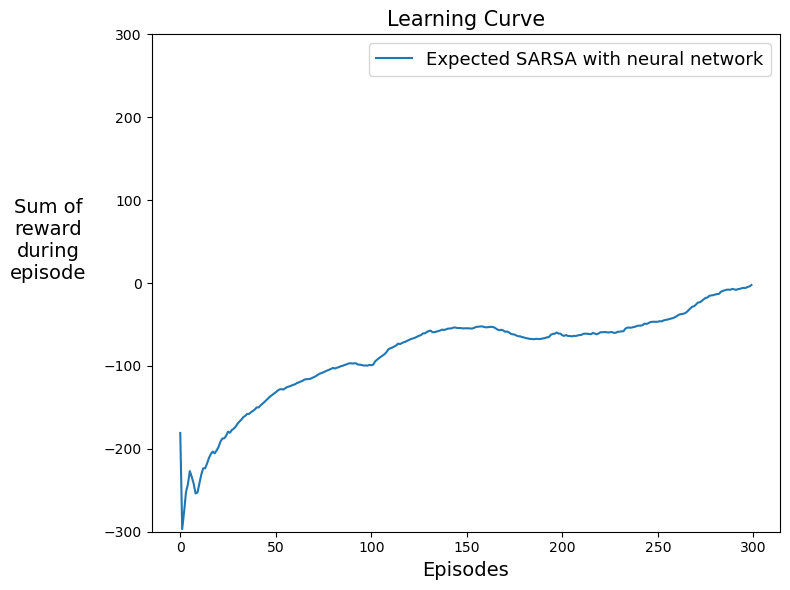

In [15]:
print("Starting!")
# Run Experiment

# Experiment parameters
experiment_parameters = {
    "num_runs": 3,
    "num_episodes": 300,
    # OpenAI Gym environments allow for a timestep limit timeout, causing episodes to end after
    # some number of timesteps. Here we use the default of 500.
    "timeout": 500
}

# Environment parameters
environment_parameters = {
    "render_mode" : 'rgb_array'}

current_env = LunarLanderEnvironment

# Agent parameters
agent_parameters = {
    'agent_name' : 'test',
    'network_config': {
        'state_dim': 8,
        'num_hidden_units': 256,
        'num_actions': 4
    },
    'optimizer_config': {
        'step_size': 1e-3,
        'beta_m': 0.9,
        'beta_v': 0.999,
        'epsilon': 1e-8
    },
    'replay_buffer_size': 50000,
    'minibatch_sz': 8,
    'num_replay_updates_per_step': 4,
    'gamma': 0.99,
    'tau': 0.001
}
current_agent = ExperienceReplay_Agent

# run experiment
rl_glue = RLGlue(current_env, current_agent)
run_experiment(rl_glue, environment_parameters, agent_parameters, experiment_parameters)

# save trained agent
joblib.dump(rl_glue.agent, "agent.pickle")

print("Finished!")
    


plt_legend_dict = {"expected_sarsa_agent_test": "Expected SARSA with neural network",
                   "random_agent": "Random"}
path_dict = {"expected_sarsa_agent_test": "results/",
             "random_agent": "./"}
plt_label_dict = {"expected_sarsa_agent_test": "Sum of\nreward\nduring\nepisode"}

plot_result(["expected_sarsa_agent_test"])


# Get the environment to run with the trained agent!

In [30]:
# Load environment
environment_parameters = {
    "render_mode" : 'human'}
env = LunarLanderEnvironment()
env.env_init(environment_parameters)

# Load agent
rl_glue.agent = joblib.load("agent.pickle") 
rl_glue.agent.num_replay = 0
rl_glue.agent.tau = 0.001

# Initialize environment
observation = env.env_start()
state = observation
reward = 0
terminal = False
max_steps_this_episode = 500
num_steps = 0

while (not terminal) and ((max_steps_this_episode == 0) or
                                     (num_steps < max_steps_this_episode)):
    action = rl_glue.rl_agent_step(reward, state)  
    reward, new_state, terminal = env.env_step(action)
    state = new_state
    num_steps += 1


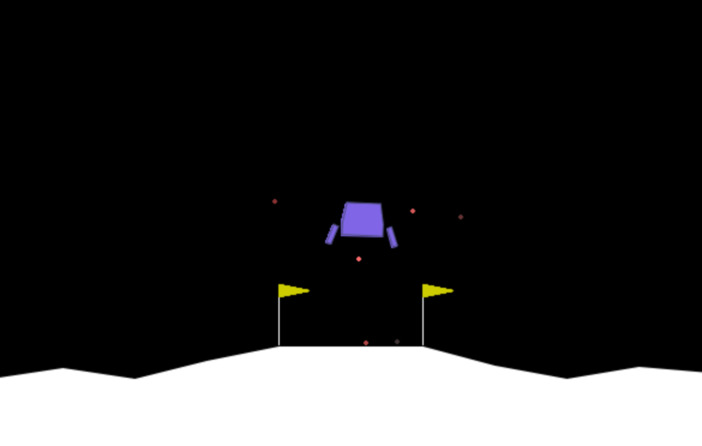